In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.ticker import FuncFormatter
import diptest
from matplotlib import rcParams

rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # matches Overleaf lmodern
    "mathtext.fontset": "cm",
    "text.latex.preamble": r"\usepackage{lmodern}\usepackage{amsmath}"
})

pd.set_option("display.width", 300)
pd.set_option("display.max_columns", 14)

# Load Data

## Load Translated 'Audience Reviews' Data, check Columns and DTypes

In [2]:
audience_reviews = pd.concat([pd.read_json(f"Rotten Tomatoes Reviews/Audience Reviews Translated/rt_audience_reviews_translated_{i}.json") for i in range(20)],ignore_index=True)
audience_reviews["creationDate"] = pd.to_datetime(audience_reviews["creationDate"])
audience_reviews["language"] = pd.Categorical(audience_reviews["language"])
audience_reviews["id"] = pd.Categorical(audience_reviews["id"])
print(audience_reviews.head())
audience_reviews.dtypes

         id                              reviewId creationDate                                userId                                         reviewText                                     originalReview language  ratingOutOfTen  originalRating        title
0  10000_bc  4ff53329-51cc-4d77-a275-0d5a637714c9   2025-07-30  78637450-3c5e-4521-912e-aaf88c667021  Success in 1 hour and 49 minutes!!!!!!!!!!!!!!...  Success in 1 hour and 49 minutes!!!!!!!!!!!!!!...       en              10             5.0  10,000 B.C.
1  10000_bc  73d7a0f3-b17d-4d8c-bc5a-a5362dacbe44   2025-07-26  bfb8057e-2996-425d-af93-7d5d4b23b8b5  I'm one of the FEW people who love this movie-...  I'm one of the FEW people who love this movie-...       en              10             5.0  10,000 B.C.
2  10000_bc  aa2c8a8a-b1d1-469a-9b04-432ad18085b7   2025-01-12  29c33bc5-e8c3-475f-9271-4903116f82be  Terrible movie. Really boring and nothing much...  Terrible movie. Really boring and nothing much...       en               1  

id                      category
reviewId                  object
creationDate      datetime64[ns]
userId                    object
reviewText                object
originalReview            object
language                category
ratingOutOfTen             int64
originalRating           float64
title                     object
dtype: object

## Load already cleaned 'Movie' Dataset

In [3]:
movies = pd.read_json("Rotten Tomatoes Reviews/rt_movies_clean.json")
movies["id"] = pd.Categorical(movies["id"])
movies["releaseDateStreaming"] = pd.to_datetime(movies["releaseDateStreaming"], errors="coerce")
movies["releaseDateTheaters"] = pd.to_datetime(movies["releaseDateTheaters"], errors="coerce")
movies["originalLanguage"] = pd.Categorical(movies["originalLanguage"])

print(movies.head())
print("\n", movies.dtypes)

                       id                     title  audienceScore  tomatoMeter ageRating                                     ratingContents releaseDateTheaters releaseDateStreaming  runtimeMinutes                        genre originalLanguage                        director  releaseYear  \
0             adrift_2018                    Adrift           65.0         69.0     PG-13  [Injury Images, Brief Drug Use, Thematic Eleme...          2018-06-01           2018-08-21           120.0  [Adventure, Drama, Romance]          English               Baltasar Kormákur       2018.0   
1  sarah_palin_you_betcha  Sarah Palin: You Betcha!           61.0         32.0      None                                                 []          2011-09-30           2017-03-08            90.0                [Documentary]          English  Nick Broomfield,Joan Churchill       2011.0   
2    a_state_of_mind_2005           A State of Mind           92.0         89.0      None                                   

# Clean Translated 'Audience Reviews' Dataset

## Locate and Drop Reviews with Non-Verbal Review Text ('language' = unknown)

In [4]:
print(f"Number of reviews with non-verbal review texts:", audience_reviews[audience_reviews["language"] == "unknown"].shape[0])
audience_reviews.drop(audience_reviews[audience_reviews["language"] == "unknown"].index, inplace=True)
audience_reviews.reset_index(inplace=True, drop=True)


Number of reviews with non-verbal review texts: 2300


## Locate and Drop Reviews that Experienced Errors in the Translation Process ('reviewText' = None)

In [5]:
print("Reviews dropped due to failed translation:", audience_reviews[audience_reviews["reviewText"].isna()].shape[0])
audience_reviews.drop(audience_reviews[audience_reviews["reviewText"].isna()].index, inplace=True)
audience_reviews.reset_index(inplace=True, drop=True)

Reviews dropped due to failed translation: 71


## Create Column Containing the Length of the Review

In [6]:
audience_reviews["reviewLength"] = audience_reviews["originalReview"].str.len()

## Save Clean 'Audience Reviews' Dataset

In [ ]:
folder = Path("Rotten Tomatoes Reviews/Audience Reviews Clean")
folder.mkdir(parents=True, exist_ok=True)

n_batches = 25

# Group by id, so all reviews concerning the same movie are in the same batch
groups = [g for _, g in audience_reviews.groupby("id", observed=False)]

# Initialize List for allocation and list of batch size to get an even split
chunks = [[] for _ in range(n_batches)]
sizes = [0] * n_batches

# Always assign the reviews concerning to the movie to the currently smallest batch
for g in groups:
    idx = np.argmin(sizes)
    chunks[idx].append(g)
    sizes[idx] += len(g)

# Save each batch as JSON
for i, chunk in enumerate(chunks):
    output_path = folder / f"rt_audience_reviews_clean_{i}.json"

    batch = pd.concat(chunk, ignore_index=True)

    batch.to_json(output_path, date_format="iso", orient="records", indent=2)
    print(f"Batch {i} saved with {len(batch)} reviews")


/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1638/3884365932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g for _, g in audience_reviews.groupby("id")]


Batch 0 saved with 66613 reviews
Batch 1 saved with 66557 reviews
Batch 2 saved with 66579 reviews
Batch 3 saved with 66559 reviews
Batch 4 saved with 66494 reviews
Batch 5 saved with 66595 reviews
Batch 6 saved with 66592 reviews
Batch 7 saved with 66716 reviews
Batch 8 saved with 66685 reviews
Batch 9 saved with 66714 reviews
Batch 10 saved with 66562 reviews
Batch 11 saved with 66544 reviews
Batch 12 saved with 66719 reviews
Batch 13 saved with 66667 reviews
Batch 14 saved with 66739 reviews
Batch 15 saved with 66509 reviews
Batch 16 saved with 66727 reviews
Batch 17 saved with 66666 reviews
Batch 18 saved with 66514 reviews
Batch 19 saved with 66625 reviews
Batch 20 saved with 66509 reviews
Batch 21 saved with 66604 reviews
Batch 22 saved with 66726 reviews
Batch 23 saved with 66544 reviews
Batch 24 saved with 66511 reviews


# Merge 'Audience Reviews' with 'Movie' Dataset

In [8]:
Working_Audience_Data = audience_reviews.merge(right=movies, how="left", on="id")
print(Working_Audience_Data[["id", "reviewId", "creationDate", "userId", "reviewText", "language", "ratingOutOfTen", "reviewLength", "genre", "releaseYear", "boxOffice"]].head())
Working_Audience_Data.dtypes

         id                              reviewId creationDate                                userId                                         reviewText language  ratingOutOfTen  reviewLength                       genre  releaseYear   boxOffice
0  10000_bc  4ff53329-51cc-4d77-a275-0d5a637714c9   2025-07-30  78637450-3c5e-4521-912e-aaf88c667021  Success in 1 hour and 49 minutes!!!!!!!!!!!!!!...       en              10           272  [Adventure, Action, Drama]       2008.0  94800000.0
1  10000_bc  73d7a0f3-b17d-4d8c-bc5a-a5362dacbe44   2025-07-26  bfb8057e-2996-425d-af93-7d5d4b23b8b5  I'm one of the FEW people who love this movie-...       en              10           178  [Adventure, Action, Drama]       2008.0  94800000.0
2  10000_bc  aa2c8a8a-b1d1-469a-9b04-432ad18085b7   2025-01-12  29c33bc5-e8c3-475f-9271-4903116f82be  Terrible movie. Really boring and nothing much...       en               1           143  [Adventure, Action, Drama]       2008.0  94800000.0
3  10000_bc  cefb401d-cd

id                            category
reviewId                        object
creationDate            datetime64[ns]
userId                          object
reviewText                      object
originalReview                  object
language                      category
ratingOutOfTen                   int64
originalRating                 float64
title_x                         object
reviewLength                     int64
title_y                         object
audienceScore                  float64
tomatoMeter                    float64
ageRating                       object
ratingContents                  object
releaseDateTheaters     datetime64[ns]
releaseDateStreaming    datetime64[ns]
runtimeMinutes                 float64
genre                           object
originalLanguage              category
director                        object
releaseYear                    float64
boxOffice                      float64
dtype: object

# Descriptive Statistics 'Audience Reviews' after Cleaning

## Summary Statistics

In [9]:
audience_reviews.describe(include="all")

,id,reviewId,creationDate,userId,reviewText,originalReview,language,ratingOutOfTen,originalRating,title,reviewLength
count,1665270,1665270,1665270,1665270,1665270,1665270,1665270,1.665270e+06,1.665270e+06,1665270,1.665270e+06
unique,9116,1665270,NaN,506308,1633045,1633244,48,NaN,NaN,8947,NaN
top,last_station,4ff53329-51cc-4d77-a275-0d5a637714c9,NaN,20f97638-9460-4b49-a86c-4f730c64ca60,It's good movie to watch,It's good movie to watch,en,NaN,NaN,Halloween,NaN
freq,250,1,NaN,3021,628,628,1551582,NaN,NaN,749,NaN
mean,NaN,NaN,2015-06-26 01:51:49.830838784,NaN,NaN,NaN,NaN,6.902846e+00,3.451423e+00,NaN,2.901625e+02
min,NaN,NaN,1996-02-08 00:00:00,NaN,NaN,NaN,NaN,1.000000e+00,5.000000e-01,NaN,7.000000e+00
25%,NaN,NaN,2011-04-11 00:00:00,NaN,NaN,NaN,NaN,5.000000e+00,2.500000e+00,NaN,6.200000e+01
50%,NaN,NaN,2014-06-20 00:00:00,NaN,NaN,NaN,NaN,7.000000e+00,3.500000e+00,NaN,1.310000e+02
75%,NaN,NaN,2020-01-19 00:00:00,NaN,NaN,NaN,NaN,9.000000e+00,4.500000e+00,NaN,2.820000e+02
max,NaN,NaN,2025-08-04 00:00:00,NaN,NaN,NaN,NaN,1.000000e+01,5.000000e+00,NaN,6.553500e+04


## Movie / Review Stats

In [10]:
print("Number of Audience Reviews:",Working_Audience_Data.shape[0])
print("Number of Movies:",Working_Audience_Data["id"].value_counts().describe()["count"])
print("Distribution Characteristics of Reviews per Movie:\n",Working_Audience_Data["id"].value_counts().describe()[["mean", "std", "min", "25%","50%","75%", "max"]])

Number of Audience Reviews: 1665270
Number of Movies: 9116.0
Distribution Characteristics of Reviews per Movie:
 mean    182.675516
std      94.586373
min       1.000000
25%      87.000000
50%     249.000000
75%     250.000000
max     250.000000
Name: count, dtype: float64


## Review Languages

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1638/3012712668.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topTenRevLanguages = Working_Audience_Data.groupby("language").agg(Languages = ("language", "first"),
/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1638/3012712668.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table = ax[0].table(cellText=topTenRevLanguages.applymap(lambda x: f"{x:,}".replace(",", "'") if isinstance(x, int) else f"{x}%" if isinstance(x, float) else x).values,


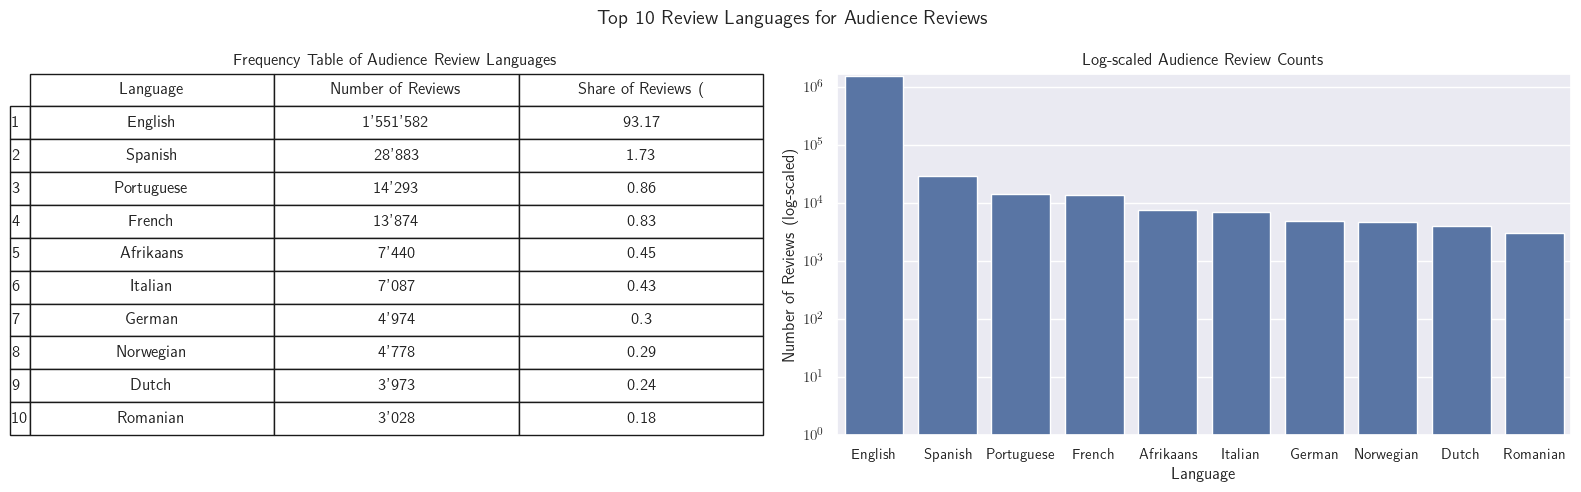

In [11]:
topTenRevLanguages = Working_Audience_Data.groupby("language").agg(Languages = ("language", "first"),
                                              NumReviews = ("language", "count")).sort_values("NumReviews", ascending=False).reset_index(drop=True)[0:10]
totalReviews = Working_Audience_Data.shape[0]

lang_map = {"en": "English",
            "es": "Spanish",
            "pt": "Portuguese",
            "fr": "French",
            "af": "Afrikaans",
            "it": "Italian",
            "de": "German",
            "no": "Norwegian",
            "nl": "Dutch",
            "ro": "Romanian"}

colLabels = {"Languages": "Language", "NumReviews" : "Number of Reviews", "ShareOfTotal": "Share of Reviews (%)"}

topTenRevLanguages["Languages"] = topTenRevLanguages["Languages"].map(lang_map)
topTenRevLanguages["ShareOfTotal"] = round(topTenRevLanguages["NumReviews"]/totalReviews*100, ndigits=2)


sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize = (16, 5))
fig.suptitle("Top 10 Review Languages for Audience Reviews", fontweight="bold")

ax[0].axis("off")
table = ax[0].table(cellText=topTenRevLanguages.applymap(lambda x: f"{x:,}".replace(",", "'") if isinstance(x, int) else f"{x}%" if isinstance(x, float) else x).values,
                  rowLabels=topTenRevLanguages.index + 1,
                  colLabels=[colLabels.get(c, c) for c in topTenRevLanguages.columns],
                  cellLoc = "center",
                  loc = "center")

ax[0].set_title("Frequency Table of Audience Review Languages")
table.scale(1, 2.1)

sns.barplot(topTenRevLanguages, x="Languages", y="NumReviews", ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_ylim(1, topTenRevLanguages["NumReviews"].max()*1.1)

ax[1].set_title("Log-scaled Audience Review Counts")
ax[1].set_xlabel("Language")
ax[1].set_ylabel("Number of Reviews (log-scaled)")


plt.tight_layout()
plt.show()

## TimeSeries of Reviews Written

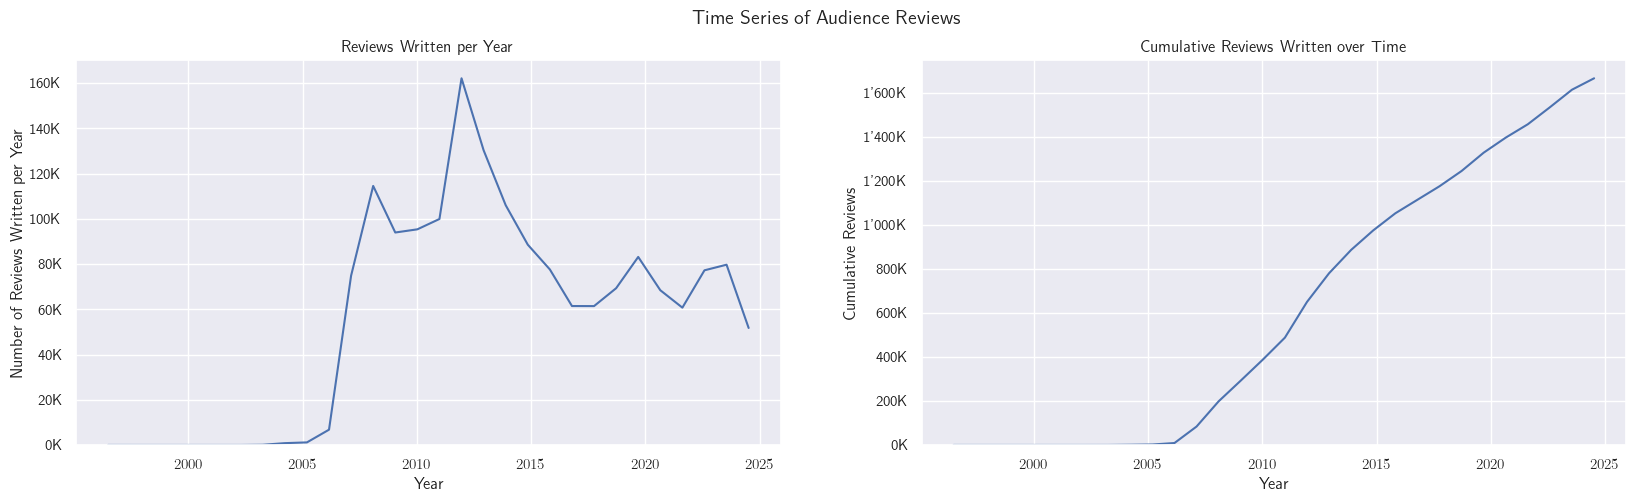

In [12]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize = (20, 5), sharex=True)
fig.suptitle("Time Series of Audience Reviews", fontweight = "bold")

sns.histplot(Working_Audience_Data["creationDate"].dt.year, bins = 30, element="poly", fill=False, ax=ax[0])
ax[0].set_title("Reviews Written per Year")
ax[0].set_ylabel("Number of Reviews Written per Year")
ax[0].set_xlabel("Year")
ax[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000):,}K".replace(",", "'")))

sns.histplot(Working_Audience_Data["creationDate"].dt.year, bins = 30, element="poly", fill=False, cumulative=True, ax=ax[1])
ax[1].set_title("Cumulative Reviews Written over Time")
ax[1].set_ylabel("Cumulative Reviews")
ax[1].set_xlabel("Year")
ax[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000):,}K".replace(",", "'")))

plt.show()

## Variable Distributions

### Distribution of Movie Ratings

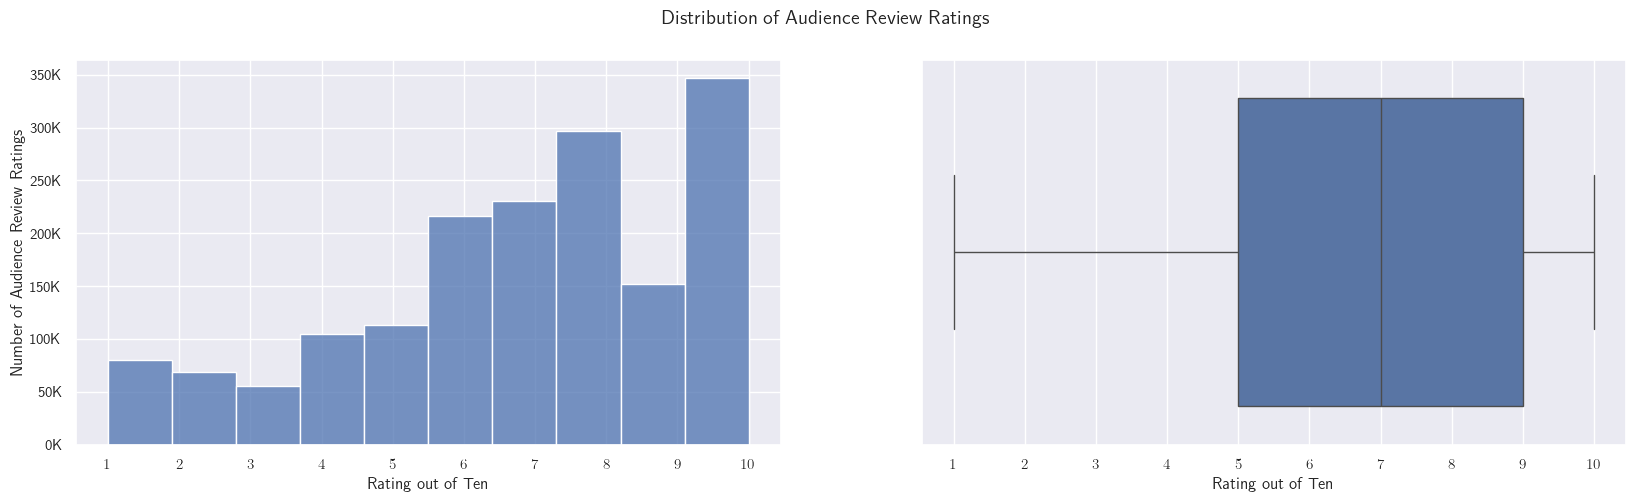

count    1.665270e+06
mean     6.902846e+00
std      2.582216e+00
min      1.000000e+00
25%      5.000000e+00
50%      7.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: ratingOutOfTen, dtype: float64

Testing H₀: The distribution of Audience Review Ratings is unimodal using Hartigan's Diptest 
Hartigan's dip statistic and p-value: 0.09034981314341417, 0.0


Hartigan's dip statistic and p-value (calculated on a sample of 72'000): 0.09035416666666667, 0.0



/Users/renatoromagna/Desktop/UZH/Masterarbeit/Master's Thesis Code/.venv/lib/python3.11/site-packages/diptest/consts.py:702: UserWarning: Sample size exceeds the maximum limit of 72000. Results may not be accurate with precomputed statistical values.
  warnings.warn(



Hartigan's dip statistic and p-value (rating range 1-7): 0.12461943349629091, 0.0



In [13]:
fig, ax = plt.subplots(1,2,figsize = (20, 5), sharex=True)
sns.set_theme(style="darkgrid")
fig.suptitle("Distribution of Audience Review Ratings", fontweight = "bold")


sns.histplot(Working_Audience_Data["ratingOutOfTen"], bins = 10, ax=ax[0])
ax[0].set_xticks(range(1,11))
ax[0].set_ylabel("Number of Audience Review Ratings")
ax[0].set_xlabel("Rating out of Ten")
ax[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000):,}K".replace(",", "'")))


sns.boxplot(Working_Audience_Data["ratingOutOfTen"], orient="h", ax=ax[1])
ax[1].set_xticks(range(1,11))
ax[1].set_xlabel("Rating out of Ten")
plt.show()

print(Working_Audience_Data["ratingOutOfTen"].describe())


dip, pval = diptest.diptest(Working_Audience_Data["ratingOutOfTen"].values)
print(f"\nTesting H₀: The distribution of Audience Review Ratings is unimodal using Hartigan's Diptest",
      f"\nHartigan's dip statistic and p-value: {dip}, {pval}\n")

sample = np.random.choice(Working_Audience_Data["ratingOutOfTen"].values, size=72000, replace=False)
dip, pval = diptest.diptest(sample)

print(f"\nHartigan's dip statistic and p-value (calculated on a sample of 72'000): {dip}, {pval}\n")

test_data = Working_Audience_Data[Working_Audience_Data["ratingOutOfTen"] <= 7]["ratingOutOfTen"].values
dip, pval = diptest.diptest(test_data)
print(f"\nHartigan's dip statistic and p-value (rating range 1-7): {dip}, {pval}\n")

### Distribution of Average Movie Ratings

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1638/2941965867.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.histplot(Working_Audience_Data.groupby("id").agg(MovieRating = ("ratingOutOfTen", "mean"))["MovieRating"].values, bins = 21, ax=ax[0])
/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1638/2941965867.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(Working_Audience_Data.groupby("id").agg(MovieRating = ("ratingOutOfTen", "mean"))["MovieRating"].values, orient="h", ax=ax[1])


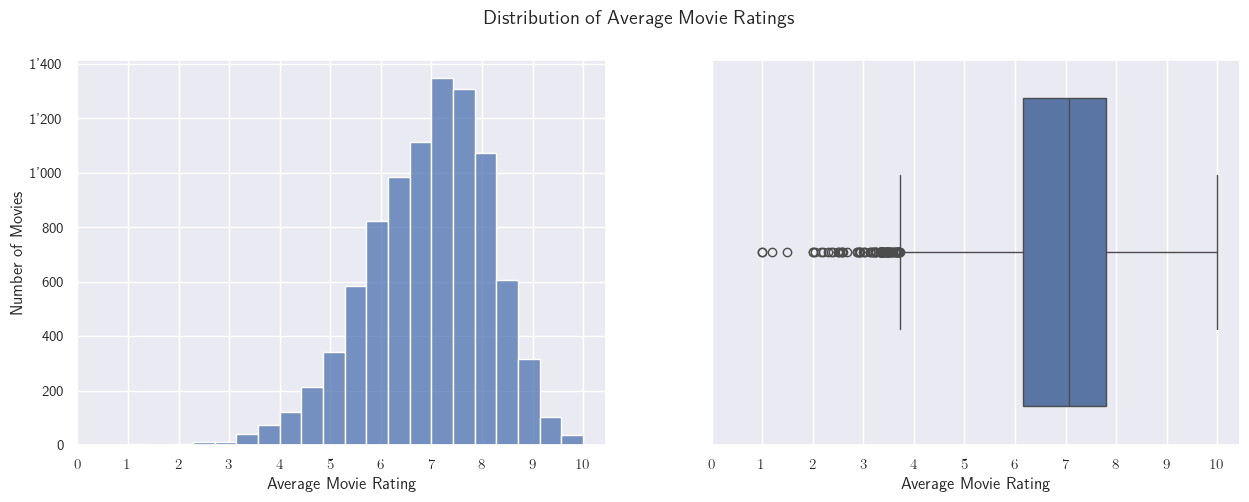

count    9116.000000
mean        6.942478
std         1.199548
min         1.000000
25%         6.168000
50%         7.066667
75%         7.800422
max        10.000000
Name: MovieRating, dtype: float64


/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1638/2941965867.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(Working_Audience_Data.groupby("id").agg(MovieRating = ("ratingOutOfTen", "mean"))["MovieRating"].describe())


In [14]:
fig, ax = plt.subplots(1,2,figsize = (15, 5), sharex=True)
sns.set_theme(style="darkgrid")
fig.suptitle("Distribution of Average Movie Ratings", fontweight="bold")

sns.histplot(Working_Audience_Data.groupby("id").agg(MovieRating = ("ratingOutOfTen", "mean"))["MovieRating"].values, bins = 21, ax=ax[0])
ax[0].set_xticks(range(11))
ax[0].set_ylabel("Number of Movies")
ax[0].set_xlabel("Average Movie Rating")
ax[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", "'")))


sns.boxplot(Working_Audience_Data.groupby("id").agg(MovieRating = ("ratingOutOfTen", "mean"))["MovieRating"].values, orient="h", ax=ax[1])
ax[1].set_xticks(range(11))
ax[1].set_xlabel("Average Movie Rating")
plt.show()

print(Working_Audience_Data.groupby("id").agg(MovieRating = ("ratingOutOfTen", "mean"))["MovieRating"].describe())

### Distribution of the Number of Reviews per Movie (Scraping was limited to 250 reviews per Movie)

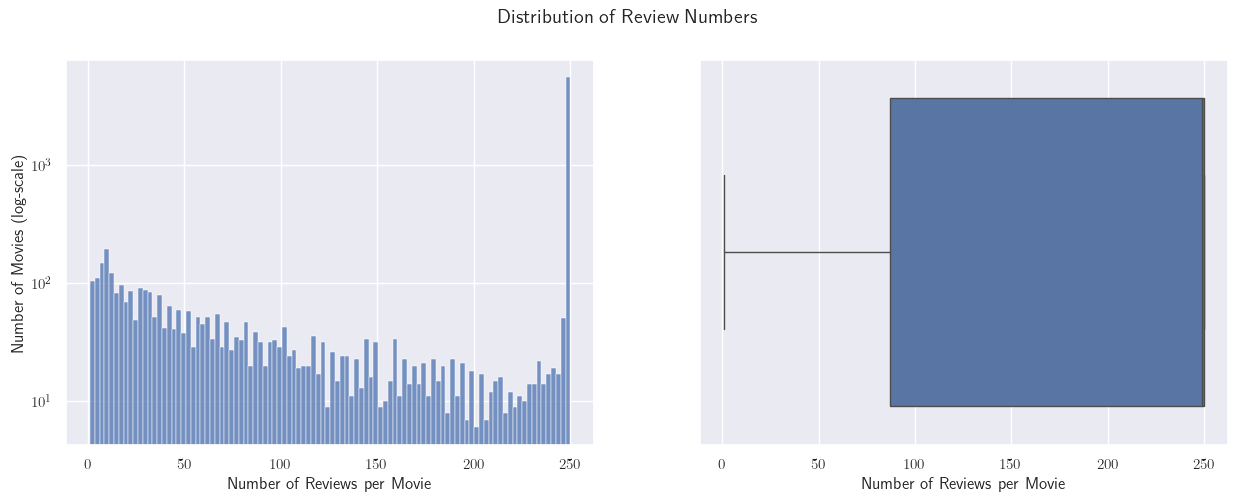

count    9116.000000
mean      182.675516
std        94.586373
min         1.000000
25%        87.000000
50%       249.000000
75%       250.000000
max       250.000000
Name: count, dtype: float64

Number of movies with 250 reviews in the data: 4130 
Fraction of movies with 250 reviews in the data: 45.3%


In [15]:
fig, ax = plt.subplots(1,2, figsize = (15, 5), sharex=True)
sns.set_theme(style="darkgrid")
fig.suptitle("Distribution of Review Numbers", fontweight = "bold")

sns.histplot(Working_Audience_Data["id"].value_counts(), bins = 100, ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("Number of Reviews per Movie")
ax[0].set_ylabel("Number of Movies (log-scale)")


sns.boxplot(Working_Audience_Data["id"].value_counts(), orient="h", ax=ax[1])
ax[1].set_xlabel("Number of Reviews per Movie")
plt.show()

print(Working_Audience_Data["id"].value_counts().describe())

print(f"\nNumber of movies with 250 reviews in the data: {Working_Audience_Data.groupby('id', observed=False).agg(Count = ('id', 'count')).reset_index()[lambda x: x['Count'] == 250].shape[0]}",
      f"\nFraction of movies with 250 reviews in the data: {round(Working_Audience_Data.groupby('id', observed=False).agg(Count = ('id', 'count')).reset_index()[lambda x: x['Count'] == 250].shape[0]/Working_Audience_Data['id'].nunique()*100, ndigits=2)}%")

### Distribution of the Number of Reviews per Reviewer

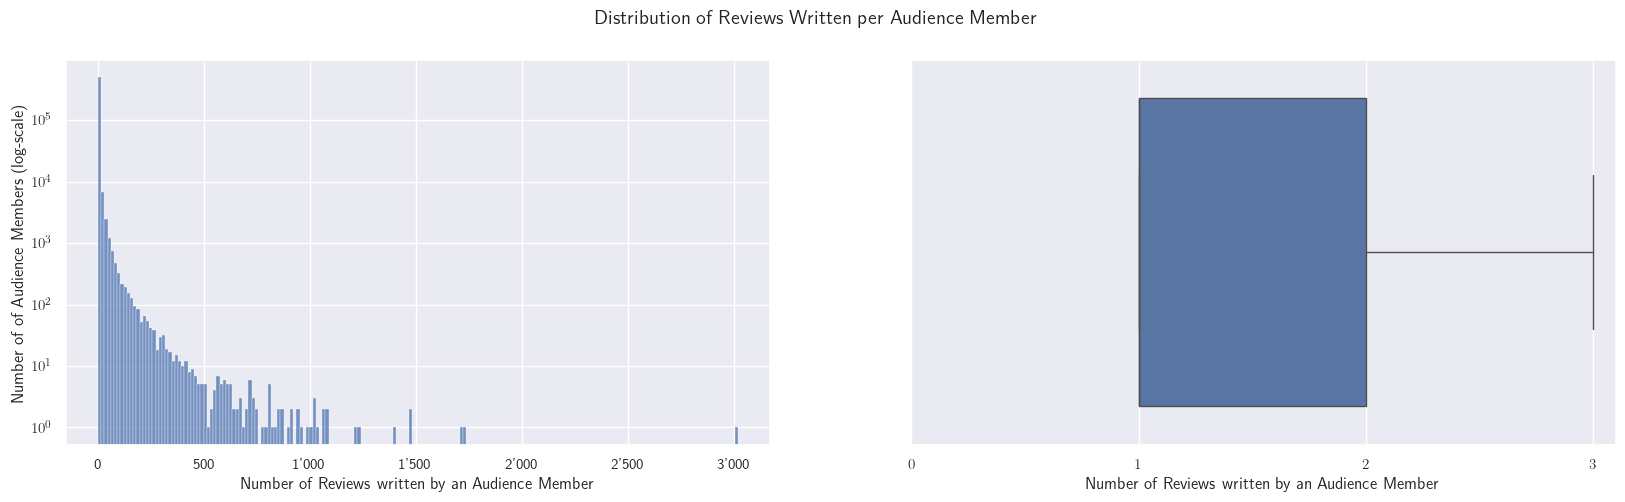

count    506308.000000
mean          3.289045
std          17.275631
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        3021.000000
Name: count, dtype: float64


In [16]:
fig, ax = plt.subplots(1,2, figsize = (20, 5))
sns.set_theme(style="darkgrid")
plt.suptitle("Distribution of Reviews Written per Audience Member", fontweight = "bold")


sns.histplot(Working_Audience_Data["userId"].value_counts(), bins = 200, ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("Number of Reviews written by an Audience Member")
ax[0].set_ylabel("Number of of Audience Members (log-scale)")
ax[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", "'")))

sns.boxplot(Working_Audience_Data["userId"].value_counts(), orient="h", showfliers=False, ax=ax[1])
ax[1].set_xlabel("Number of Reviews written by an Audience Member")
ax[1].set_xticks(range(4))
plt.show()

print(Working_Audience_Data["userId"].value_counts().describe())


### Distribution of Review Text Length

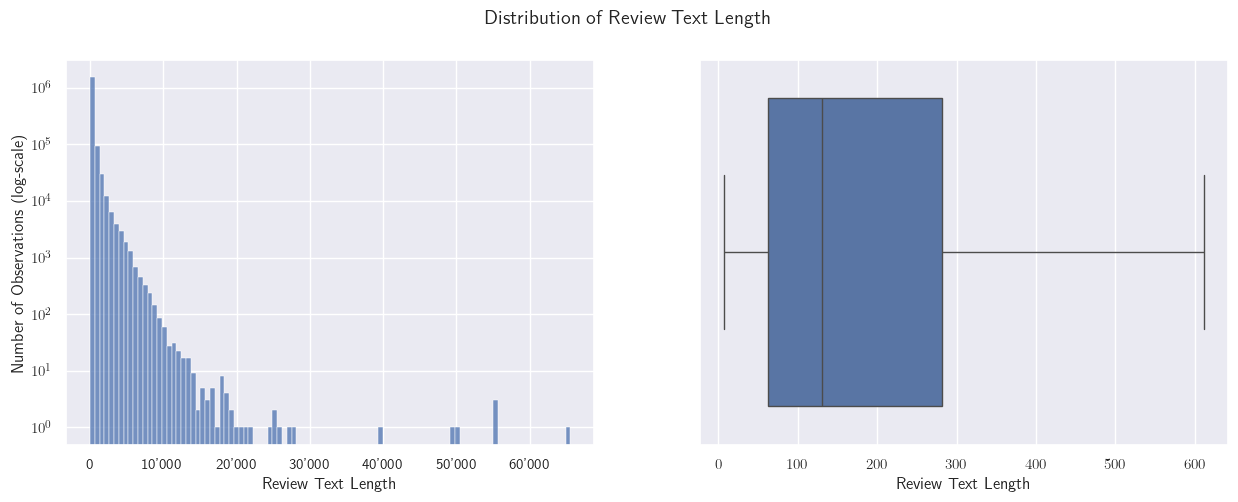

count    1.665270e+06
mean     2.901625e+02
std      5.761179e+02
min      7.000000e+00
25%      6.200000e+01
50%      1.310000e+02
75%      2.820000e+02
max      6.553500e+04
Name: reviewLength, dtype: float64


In [17]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.set_theme(style="darkgrid")
fig.suptitle("Distribution of Review Text Length", fontweight = "bold")

sns.histplot(Working_Audience_Data["reviewLength"], bins = 100, ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("Review Text Length")
ax[0].set_ylabel("Number of Observations (log-scale)")
ax[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", "'")))

sns.boxplot(Working_Audience_Data["reviewLength"], orient="h", showfliers=False, ax=ax[1])
ax[1].set_xlabel("Review Text Length")
plt.show()

print(Working_Audience_Data["reviewLength"].describe())

### Distribution of Movie Box Office

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1638/906375085.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.histplot(Working_Audience_Data.groupby("id").head(1)["boxOffice"], bins = 100, ax=ax[0])
/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1638/906375085.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(Working_Audience_Data.groupby("id").head(1)["boxOffice"], orient="h", showfliers=False, ax=ax[1])


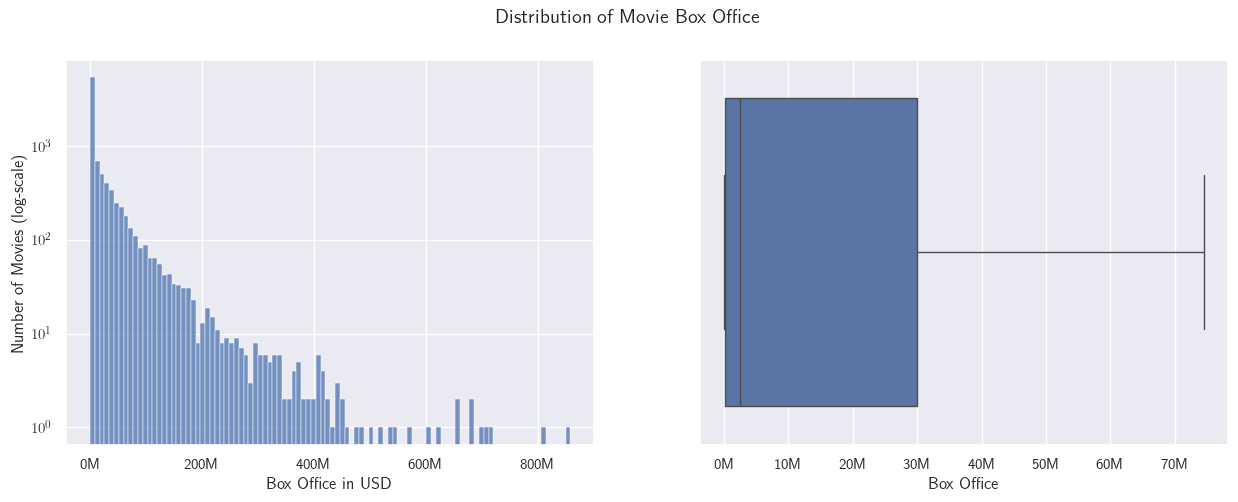

count    1.665270e+06
mean     3.615527e+07
std      6.571872e+07
min      3.690000e+02
25%      7.547000e+05
50%      1.150000e+07
75%      4.310000e+07
max      8.584000e+08
Name: boxOffice, dtype: float64


In [18]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.set_theme(style="darkgrid")
fig.suptitle("Distribution of Movie Box Office", fontweight="bold")

sns.histplot(Working_Audience_Data.groupby("id").head(1)["boxOffice"], bins = 100, ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("Box Office in USD")
ax[0].set_ylabel("Number of Movies (log-scale)")
ax[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000000):,}M".replace(",", "'")))


sns.boxplot(Working_Audience_Data.groupby("id").head(1)["boxOffice"], orient="h", showfliers=False, ax=ax[1])
ax[1].set_xlabel("Box Office")
ax[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000000):,}M".replace(",", "'")))
plt.show()

print(Working_Audience_Data["boxOffice"].describe())

## Scatter Plots

### Review Length on Review Rating

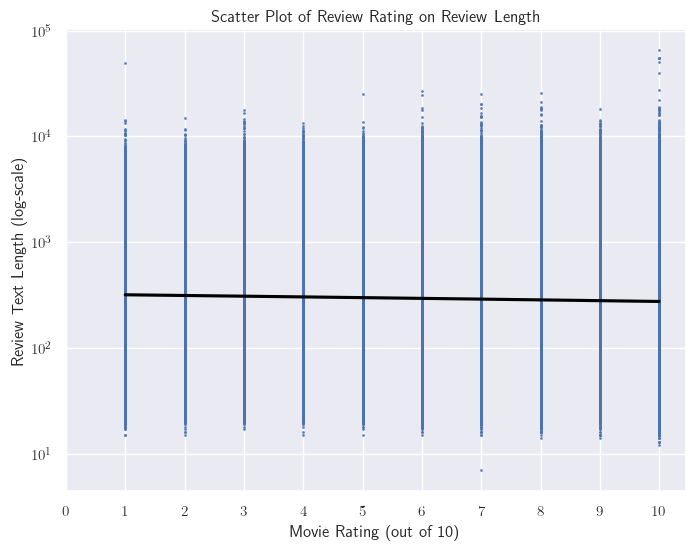

Pearson Correlation: -0.0214


In [19]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(8,6))

sns.regplot(x=Working_Audience_Data["ratingOutOfTen"], 
            y=Working_Audience_Data["reviewLength"], 
            scatter_kws={"s": 1}, 
            line_kws={"color":"black"},
            ax=ax)

ax.set_title("Scatter Plot of Review Rating on Review Length", fontweight="bold")
ax.set_xticks(range(11))
ax.set(yscale="log")
ax.set_xlabel("Movie Rating (out of 10)")
ax.set_ylabel("Review Text Length (log-scale)")
plt.show()

print("Pearson Correlation:", round(Working_Audience_Data["ratingOutOfTen"].corr(Working_Audience_Data["reviewLength"]), ndigits=4))

### Box Office on Average Movie Rating

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1638/1869363043.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_rating_data = Working_Audience_Data.groupby("id").agg(meanRating = ("ratingOutOfTen", "mean"),


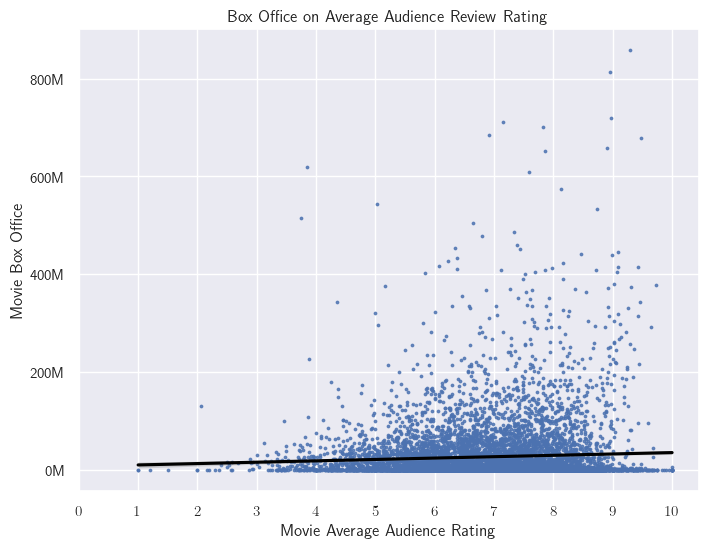

Pearson Correlation: 0.0574


In [20]:
plot_rating_data = Working_Audience_Data.groupby("id").agg(meanRating = ("ratingOutOfTen", "mean"),
                                                         boxOffice = ("boxOffice", "first")).dropna()             # RatingOutOfTen contains NaNs (but only in Critic Review Dataset, boxOffice NaN got dropped in Audience reviews, might change though)
fig, ax = plt.subplots(figsize = (8,6))
sns.set_theme(style="darkgrid")

sns.regplot(x=plot_rating_data["meanRating"], 
            y=plot_rating_data["boxOffice"],
            scatter_kws={"s": 3},
            line_kws={"color":"black"},
            ax=ax)

ax.set_title("Box Office on Average Audience Review Rating", fontweight="bold")
ax.set_xlabel("Movie Average Audience Rating")
ax.set_ylabel("Movie Box Office")
ax.set_xticks(range(11))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000000):,}M".replace(",", "'")))
plt.show()

print("Pearson Correlation:", round(np.corrcoef(
    x=plot_rating_data["meanRating"], 
    y=plot_rating_data["boxOffice"])[0, 1], 4))

### Box Office on Number of Reviews (not very useful because max 250 reviews got scraped per Movie)

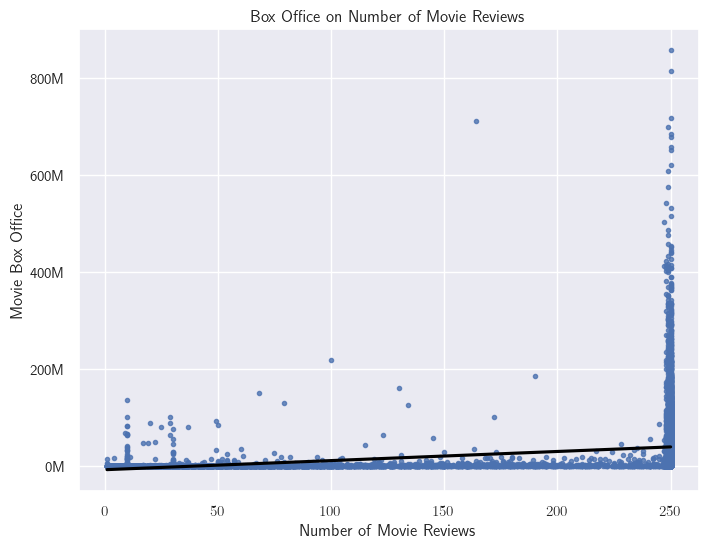

Pearson Correlation: 0.3036


In [21]:
fig, ax = plt.subplots(figsize=(8,6))
sns.set_theme(style="darkgrid")

sns.regplot(x = Working_Audience_Data["id"].value_counts().sort_index().values, 
            y = Working_Audience_Data[["id", "boxOffice"]].drop_duplicates("id").sort_values("id")["boxOffice"].values, marker=".", line_kws={"color":"black"}, ax=ax)
ax.set_title("Box Office on Number of Movie Reviews", fontweight="bold")
ax.set_xlabel("Number of Movie Reviews")
ax.set_ylabel("Movie Box Office")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000000):,}M".replace(",", "'")))
plt.show()

print("Pearson Correlation:", round(np.corrcoef(
    x=Working_Audience_Data["id"].value_counts().sort_index().values, 
    y=Working_Audience_Data[["id", "boxOffice"]].drop_duplicates("id").sort_values("id")["boxOffice"].values)[0][1], ndigits=4))

### Box Office on Average Review Text Length

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1638/1160059617.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.regplot(x = Working_Audience_Data.groupby("id").agg(AvgReviewLen = ("reviewLength", "mean"))["AvgReviewLen"].values,


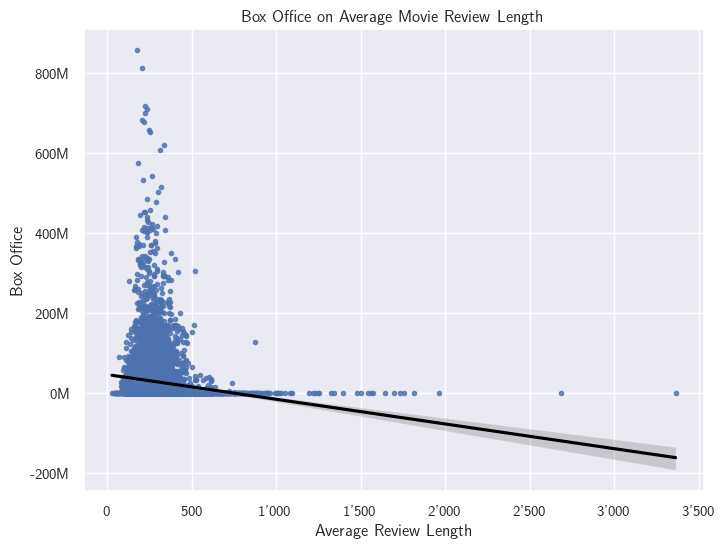

Pearson Correlation: -0.1406


/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1638/1160059617.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x=Working_Audience_Data.groupby("id").agg(AvgRevLen=("reviewLength", "mean"))["AvgRevLen"].values,


In [22]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(8,6))

sns.regplot(x = Working_Audience_Data.groupby("id").agg(AvgReviewLen = ("reviewLength", "mean"))["AvgReviewLen"].values, 
            y = Working_Audience_Data[["id", "boxOffice"]].drop_duplicates("id").sort_values("id")["boxOffice"].values,
            marker=".",
            line_kws={"color":"black"},
            ax = ax)

ax.set_title("Box Office on Average Movie Review Length", fontweight="bold")
ax.set_xlabel("Average Review Length")
ax.set_ylabel("Box Office")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000000):,}M".replace(",", "'")))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", "'")))
plt.show()

print("Pearson Correlation:", round(np.corrcoef(
        x=Working_Audience_Data.groupby("id").agg(AvgRevLen=("reviewLength", "mean"))["AvgRevLen"].values,
        y=Working_Audience_Data[["id", "boxOffice"]].drop_duplicates("id").sort_values("id")["boxOffice"].values)[0, 1], 4))